## Imports

In [16]:
import numpy as np
from scipy.io import loadmat
import scipy
import networkx as nx
import matplotlib.pyplot as plt
from functools import lru_cache

## working with Leo's data

In [17]:
annots = loadmat('/home/kunal/Downloads/MaxCut_Fourier_u3R.mat')
print(annots.keys())

dict_keys(['__header__', '__version__', '__globals__', 'DataFourier', 'DataFourierRP', 'Ns', 'maxP', 'GraphData', 'numGraphs'])


In [18]:
# fields: ratio, param, overlaps, userTime
[annots['DataFourierRP'][0][0][i].shape for i in range(len(annots['DataFourierRP'][0][0]))]

[(20, 100), (20, 100), (20, 2, 100), (20, 100)]

In [19]:
Ns = annots['Ns'][0]
num_graphs = annots['numGraphs'][0]
maxP = annots['maxP'][0][0]

## generate max cut

leo's method:

In [20]:
@lru_cache(maxsize=None)
def get_kron(N,i,j):
    sz = [1,-1]
    L = 2**(i-1)
    M = 2**(j-i-1)
    R = 2**(N-j)
    outT1 = np.kron(np.ones(L), sz)
    outT2 = np.kron(outT1, np.ones(M))
    outT3 = np.kron(outT2, sz)
    out = np.kron(outT3, np.ones(R))
    return out

In [21]:
def get_H(N, edges):
    H = np.zeros(2**N)
    for i,j in edges:
        H = H + (1 - get_kron(N, i, j))/2
    return H

In [22]:
## old method: powerset

# from itertools import chain, combinations

# def powerset(iterable):
#     "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
#     s = list(iterable)
#     return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

## alr algorithm

In [23]:
def ALR(g):
    # Get adjacency matrix and eigenvectors
    nodes = sorted(g.nodes())
    n = len(nodes)
    m = nx.linalg.graphmatrix.adjacency_matrix(g, nodelist=nodes).asfptype().T.toarray()
    w, v = scipy.linalg.eig(m)
    
    min_eig_idxs = np.where(w == np.min(w))[0]
    cut = 0
    for idx in min_eig_idxs:
    # average over minimum eigenvectors (there are multiple when graph is disconnected, for example)
        eigvec = v[:, idx]
        # normalize eigenvector
        eigvec = eigvec * n**0.5 / np.linalg.norm(eigvec)

        # make cut from sign of eigenvector
        signs = np.sign(eigvec)
        S = [n for n, x in zip(nodes, signs) if x >= 0]
        cut += nx.cut_size(g, S)
    cut = cut/len(min_eig_idxs)
    return cut

## run process

In [24]:
from functools import lru_cache

@lru_cache(maxsize=None)
def script(N, p, graph_num, show_prints=True):
    pr = print if show_prints else lambda *x: x
        
    assert N in Ns, "choose N from 8, 10, 12, 14, 16, 18, 20, 22"
    idx = np.where(Ns == N)[0][0]
    assert annots['GraphData'][0][idx][0] == N
    assert annots['GraphData'][0][idx][2] == 'u3R'
    assert annots['GraphData'][0][idx][1].size == num_graphs[idx]
    pr("N:", N)
    pr("number of graphs:", num_graphs[idx])
    
    assert graph_num < num_graphs[idx], "graph_num must be less than " + str(num_graphs[idx])
    assert 1 <= p and p <= maxP, "must be p in 1-" + str(maxP)
    pr("p:", p)
    pr("graph num:", graph_num)
    
    ratio = annots['DataFourierRP'][0][idx][0][p-1][graph_num]
    pr("approx ratio:", ratio)
    
    graph_edges = annots['GraphData'][0][idx][1][0][graph_num]
    G = nx.parse_edgelist([str(e[0]) + " " + str(e[1]) for e in graph_edges], nodetype = int)
    G = nx.convert_node_labels_to_integers(G, first_label=1)
    # get max cut
    max_cut = max(get_H(N, G.edges()))
# #     # CThis matches leo's method for all N=8 and 10...
#     all_subsets = powerset(list(G.nodes()))
#     all_cut_sizes = [nx.cut_size(G, S) for S in all_subsets]
#     max_cut_2 = max(all_cut_sizes)
#     pr("max cut:", max_cut, max_cut_2)
#     return max_cut != max_cut_2

    pr("total number of edges:", len(graph_edges))
    pr("max cut:", max_cut)
    qaoa_average_cut = ratio*max_cut
    pr("qaoa average cut:", qaoa_average_cut)
    alr_cut = ALR(G)
    pr("ALR cut:", alr_cut)
    return alr_cut >= qaoa_average_cut

## testing it out

In [29]:
# Edit these values
N = 16
p = 3
graph_num = 20

In [30]:
script(N, p, graph_num, show_prints=True)

True

N = 8
N = 10
N = 12
N = 14
N = 16
N = 18
CPU times: user 1min 25s, sys: 334 ms, total: 1min 26s
Wall time: 1min 26s


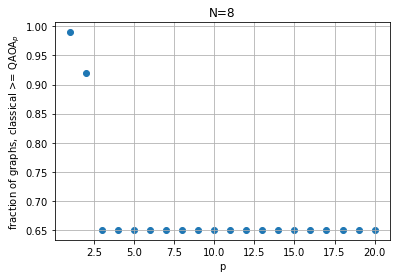

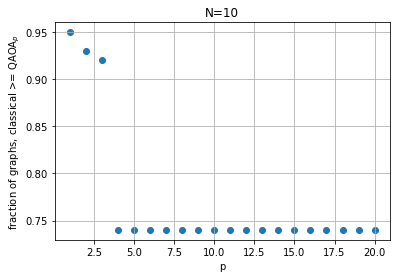

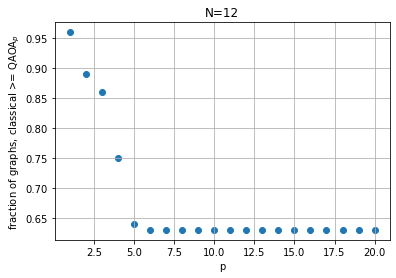

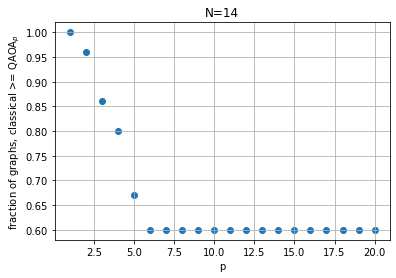

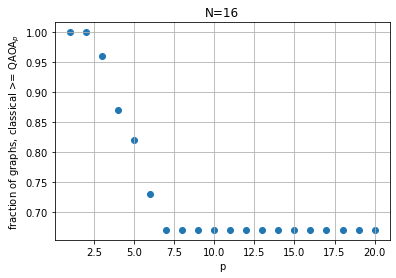

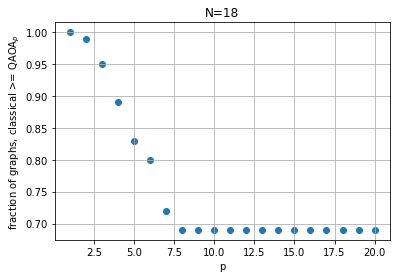

In [33]:
%%time
for N in [8,10,12,14,16,18]:
    print("N =", N)
    plt.figure()
    ps = range(1, 21)
    fracs = [sum([script(N, p, i, show_prints=False) for i in range(100)])/100 for p in ps]
    plt.scatter(ps, fracs)
    plt.xlabel("p")
    plt.ylabel("fraction of graphs, classical >= QAOA$_p$")
    plt.title("N=" + str(N))
    plt.grid()
    plt.savefig('N=' + str(N) + '.png')

In [ ]:
#nx.draw